In [198]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [199]:
def step(t, dt):
    t = t + dt
    return t

In [200]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

    #     print("x-loc rectangle,", x, "y-loc rectangle,", y)

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [201]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [202]:
class camera(object):
    def __init__(self, length_v):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []  # time when fruit was picked

        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        view_min = q_curr - self.width / 2
        view_max = q_curr + self.width / 2

        # fix end constraints of beginning and end 
        if view_min < 0:
            view_min = 0

        if view_max > end_row:
            view_max = end_row
            
        j = self.i_lastFruit
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > view_min and sortedFruit[1,j] < view_max:
                if sortedFruit[3,j] == 0:
                    # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                    # so it can't really be used either way as a goal
                    key = math.ceil(sortedFruit[1,j]*1000) 
                    # add the value to the b-tree
                    self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > view_max:
                # no fruit left to add
                break
            j = j + 1
            
#         self.i_lastFruit = i
        self.i_lastFruit = j
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [203]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [204]:
class arm(object):
    def __init__(self, q, n, frame_width):
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.q_zero        = np.array([q[0],q[1],q[2]])  # arm's zero location (can go back to it)
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 4.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = 4.           # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([self.q_a[0],self.q_a[1],self.q_a[2]/2])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.])
        self.y_edges_f     = np.array([0.,0.])
        self.z_edges_f     = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = 1.
        self.a_max         = 10. 
        self.d_max         = 10.
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
#     def armStep(self, v_v, q_curr, dt, t):
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # q_curr is the arm's current location within the world frame
        q_curr      = np.array([0.,0.,0.])
        # v_v is the vehicle's velocity
        q_curr[0]   = self.q_a[0]
        q_curr[1]   = self.q_a[1]
        q_curr[2]   = self.q_a[2]

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
#                 print("AND AFTER?", self.retractFlag)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # check if goal was actually reached
#         if (self.q_a[0] + epsilon < self.goal[0]) or (self.q_a[0] - epsilon > self.goal[0]) and self.goal_r[0] == 1: 
#             self.goal_r[0] = 0
            
#         if (self.q_a[1] + epsilon < self.goal[1]) or (self.q_a[1] - epsilon > self.goal[1]) and self.goal_r[1] == 1: 
#             self.goal_r[1] = 0
            
#         if (self.q_a[2] + epsilon < self.goal[2]) or (self.q_a[2] - epsilon > self.goal[2]) and self.goal_r[2] == 1: 
#             self.goal_r[2] = 0
            
        # update the zero location to follow the vehicle
        self.q_zero[0] += v_v[0]*dt
        self.q_zero[1] += v_v[1]*dt
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         print("")
#         print("ARM:", self.n)
#         print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)
        
#         print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#         print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]+epsilon) or self.q_a[0] < (self.goal[0]-epsilon)) and
                (self.q_a[1] > (self.goal[1]+epsilon) or self.q_a[1] < (self.goal[1]-epsilon)) and
                (self.q_a[2] > (self.goal[2]+epsilon) or self.q_a[2] < (self.goal[2]-epsilon))):
                # find a better way to do this 
                self.reached_goals += 1
    #                     print("GOAL REACHED")
                # "pick" the fruit
                picture.fruitPicked(self.goal, t)
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_zero[0]+epsilon or self.q_a[0] < self.q_zero[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0.
                
            elif self.retractFlag == 0:
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_zero[0], self.x.v0, self.v_max, self.a_max, self.d_max)
#         print("RETRACTING")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)       
#         print(" ")
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
        print(" ")
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
        print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
        print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
        print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
        print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future"
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is passed the edge of the back frame

            if self.goal[2] < self.z_edges_f[0] and self.goal[2] > self.z_edges_f[1]:
                # check again if the goal is within the top and bottom of the frame
                return 1

            else:
                return 0
        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [205]:
# open CSV file and populate fruits on grid
x_fr = []
y_fr = []
z_fr = []

# with open('Applestotheleft.csv', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
#     for row in spamreader:
#         x_fr.append(float(row[0]))
#         y_fr.append(float(row[1]))
#         z_fr.append(float(row[2]))
        
with open('Applestotheright.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        x_fr.append(float(row[0]))
        y_fr.append(float(row[1]))
        z_fr.append(float(row[2]))

x_fruit = np.array(x_fr)
y_fruit = np.array(y_fr)
z_fruit = np.array(z_fr)
picked  = np.zeros(len(x_fruit))

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x_fr, y_fr, z_fruit, picked])

rowIndex = 1 # sort based on y-axis
sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [206]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 17.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

dr = drawRobot()

In [207]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
num_row_arms = 1                 # set the number of ros of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis         

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)
print("length of the vehicle:", length_v)

q_v = np.array([5.5,9.])    # starting location
v_v = np.array([0.,0.003])  # in m, constant velocity
# v_v = np.array([0.,0.])  # in m, constant velocity to easily change between the two

qv0 = []
qv1 = []

length of the vehicle: 9.0


In [208]:
# init camera
picture = camera(length_v)

In [209]:
# init scheduler
goal = np.zeros(3) # does ithis go here?

In [210]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2 
# set location for 0th arm 
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.])

a = []  # list of arm objects 

# initialize the arms in a list
for count in range(num_arms):
    # calculate where each new arm should go
    q_a_new[0] = q_a[0]             # doesn't change right now
    q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
    q_a_new[2] = q_a[2]             # doesn't change right now
    # initialize the new arm
    x = arm(q_a_new, count, frame_width)
    # add the arm to the a-list
    a.append(x)

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []

In [211]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    
    # schedule
    # check if there are any arms that are free 
    for arm_free in range(num_arms):
#         if a1.free == 1:
        if a[arm_free].free == 1 and len(picture.fruitBTree) > 0:
            # get the location of this arm's back edge and convert to integer to get a value to compare keys
            potential_key = math.ceil(a[arm_free].y_edges_f[1]*1000) + 3
            # find a value in the B-tree that fits it's location 
            key = picture.fruitBTree.minKey(potential_key)
            # set the index's fruit as picked
            sortedFruit[3,goal_new] = 1 
            # choose the first fruit as a goal to be given to the arm
            goal_new = picture.fruitBTree.pop(key)
            # set the new goal
            a[arm_free].setGoal(sortedFruit[0:3,goal_new], t_new)
            ### make sure there are available goals left in the b-tree at some point
            ### the arms will get ahead of their frames. Fix that

            ## look into B-Trees 
            ## https://ebrary.net/25936/computer_science/b-tree_organization
            ## https://cstack.github.io/db_tutorial/parts/part7.html

    
    # have each arm take a step
    for arm2step in range(num_arms):
        q_a = a[arm2step].armStep(v_v, dt, t_new)

#    # when the vehicle is stopped, gives an end to the while loop
#     if a1.error[1] == math.inf or a1.error[1] == -math.inf:
#         print("end of the fruit in y")
#         break
    
#     if a1.error[2] == math.inf or a1.error[2] == -math.inf:
#         print("end of the fruit in z")
#         break
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(a[0].x_edges_f[0]))
    front_edge.append(float(a[0].y_edges_f[0]))
    back_edge.append(float(a[0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 5.5 9.8678696059 0
start, end, start velocity: 6.0 5.3231695488 0
start, end, start velocity: 4.0 1.1919865482 0
 
X-axis, Ta: 0.1 Tv: 4.2678696059 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.5768304511999999 Td: 0.1
Z-axis, Ta: 0.1 Tv: 2.7080134518 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 5.5 8.2155859972 0
start, end, start velocity: 9.0 7.5099152899 0
start, end, start velocity: 4.0 3.7314053709 0
 
X-axis, Ta: 0.1 Tv: 2.6155859971999997 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.3900847100999996 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.16859462909999987 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 5.5 7.3876242643 0
start, end, start velocity: 12.0 10.5317158108 0
start, end, start velocity: 4.0 6.1780239396 0
 
X-axis, Ta: 0.1 Tv: 1.7876242643000002 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.36828418920

start, end, start velocity: 5.500000000000654 9.1714442834 0
start, end, start velocity: 5.335962410026356 5.4430205073 0
start, end, start velocity: 2.4580419336000188 1.7916745617 0
 
X-axis, Ta: 0.1 Tv: 3.571444283399346 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.0070580972736436765 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.5663673719000187 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 9.159085815299353 5.5 0
start, end, start velocity: 9.083643290899364 5.5 0
start, end, start velocity: 5.500000000000648 8.4780245369 0
start, end, start velocity: 7.576024008263891 7.61187722 0
start, end, start velocity: 2.641754906299802 3.4941797119 0
 
X-axis, Ta: 0.1 Tv: 2.878024536899351 Td: 0.1
Y-axis, Ta: 0.05987755149979749 Tv: 0 Td: 0.05987755149979749
Z-axis, Ta: 0.1 Tv: 0.7524248056001982 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5987755149979749 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start

start, end, start velocity: 5.500000000002162 9.7934050359 0
start, end, start velocity: 5.669485242284369 5.8026858964 0
start, end, start velocity: 2.3990189406999574 1.3457282395 0
 
X-axis, Ta: 0.1 Tv: 4.193405035897838 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.03320065411563053 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.9532907011999573 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 5.500000000001554 7.9383157563 0
start, end, start velocity: 7.75960229435356 7.7743422782 0
start, end, start velocity: 1.8771065744996729 7.9968441201 0
 
X-axis, Ta: 0.1 Tv: 2.3383157562984453 Td: 0.1
Y-axis, Ta: 0.03839268660362216 Tv: 0 Td: 0.03839268660362216
Z-axis, Ta: 0.1 Tv: 6.019737545600327 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3839268660362216 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.500000000001554 6.9822861713 0
start, end, start velocity: 7.75963229435356 7.7

start, end, start velocity: 8.57838436919836 5.5 0
start, end, start velocity: 9.075788180698096 5.5 0
start, end, start velocity: 9.771737354397722 5.5 0
start, end, start velocity: 5.50000000000164 8.5567195037 0
start, end, start velocity: 11.351463736519538 11.3623173569 0
start, end, start velocity: 3.214942427998891 3.1303465072 0
 
X-axis, Ta: 0.1 Tv: 2.9567195036983605 Td: 0.1
Y-axis, Ta: 0.03294483325267038 Tv: 0 Td: 0.03294483325267038
Z-axis, Ta: 0.09197604079263856 Tv: 0 Td: 0.09197604079263856
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3294483325267038 10.0 10.0
reached values, Z: -0.9197604079263856 -10.0 -10.0
 
start, end, start velocity: 5.500000000001906 7.8880462924 0
start, end, start velocity: 5.883075276553416 5.9278863172 0
start, end, start velocity: 0.6002939427001686 4.2075675354 0
 
X-axis, Ta: 0.1 Tv: 2.288046292398094 Td: 0.1
Y-axis, Ta: 0.06694104917506384 Tv: 0 Td: 0.06694104917506384
Z-axis, Ta: 0.1 Tv: 3.5072735926998315 Td: 0.1
 
reached v

start, end, start velocity: 5.499999999996623 6.9777422126 0
start, end, start velocity: 8.16781013801955 8.1704803294 0
start, end, start velocity: 0.8867281554995448 8.4984635603 0
 
X-axis, Ta: 0.1 Tv: 1.3777422126033767 Td: 0.1
Y-axis, Ta: 0.01634072024253961 Tv: 0 Td: 0.01634072024253961
Z-axis, Ta: 0.1 Tv: 7.511735404800455 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.1634072024253961 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996623 9.7810065184 0
start, end, start velocity: 8.167840138019551 8.1717457001 0
start, end, start velocity: 0.8867281554995448 1.0112443587 0
 
X-axis, Ta: 0.1 Tv: 4.181006518403377 Td: 0.1
Y-axis, Ta: 0.019762494985323446 Tv: 0 Td: 0.019762494985323446
Z-axis, Ta: 0.1 Tv: 0.024516203200455194 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.19762494985323445 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.641708345802792 5.5 0
start, end, start velocity

start, end, start velocity: 5.499999999996916 7.9472895566 0
start, end, start velocity: 11.53275395824678 11.5374681612 0
start, end, start velocity: 1.9556398421995715 5.2712000339 0
 
X-axis, Ta: 0.1 Tv: 2.347289556603084 Td: 0.1
Y-axis, Ta: 0.021712215348094577 Tv: 0 Td: 0.021712215348094577
Z-axis, Ta: 0.1 Tv: 3.215560191700428 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.21712215348094577 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996916 9.1698792312 0
start, end, start velocity: 11.53278395824678 11.5526705688 0
start, end, start velocity: 1.9556398421995715 1.4531402558 0
 
X-axis, Ta: 0.1 Tv: 3.569879231203083 Td: 0.1
Y-axis, Ta: 0.044594406098994135 Tv: 0 Td: 0.044594406098994135
Z-axis, Ta: 0.1 Tv: 0.4024995863995716 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4459440609899413 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 9.911469043903919 5.5 0
start, end, start vel

start, end, start velocity: 5.499999999996641 7.7836426994 0
start, end, start velocity: 6.52840822708768 6.5606899215 0
start, end, start velocity: 2.8015223300997225 4.8460626482 0
 
X-axis, Ta: 0.1 Tv: 2.1836426994033586 Td: 0.1
Y-axis, Ta: 0.056816981979263805 Tv: 0 Td: 0.056816981979263805
Z-axis, Ta: 0.1 Tv: 1.9445403181002776 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.568169819792638 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996641 7.9787818672 0
start, end, start velocity: 6.52843822708768 6.5908828508 0
start, end, start velocity: 2.8015223300997225 5.052131775 0
 
X-axis, Ta: 0.1 Tv: 2.3787818672033594 Td: 0.1
Y-axis, Ta: 0.07902191070350058 Tv: 0 Td: 0.07902191070350058
Z-axis, Ta: 0.1 Tv: 2.1506094449002777 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7902191070350058 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996641 9.3919441802 0
start, end, start vel

reached values, Y: 0.5757140264895351 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.4999999999968985 8.0456302776 0
start, end, start velocity: 6.6485577430912315 6.6551171984 0
start, end, start velocity: 0.8255227876998907 4.340675944 0
 
X-axis, Ta: 0.1 Tv: 2.4456302776031023 Td: 0.1
Y-axis, Ta: 0.025611433596674494 Tv: 0 Td: 0.025611433596674494
Z-axis, Ta: 0.1 Tv: 3.4151531563001094 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.25611433596674493 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.4999999999968985 7.5264664522 0
start, end, start velocity: 6.648587743091231 6.6765618552 0
start, end, start velocity: 0.8255227876998907 5.4654702567 0
 
X-axis, Ta: 0.1 Tv: 1.9264664522031016 Td: 0.1
Y-axis, Ta: 0.0528905588066234 Tv: 0 Td: 0.0528905588066234
Z-axis, Ta: 0.1 Tv: 4.53994746900011 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.528905588066234 10.0 10.0
reached values, Z: 1.0 10.0 10.0

 
start, end, start velocity: 5.4999999999965965 8.0655797807 0
start, end, start velocity: 8.52110245743382 8.5897312792 0
start, end, start velocity: 1.3094137721983228 4.9481375298 0
 
X-axis, Ta: 0.1 Tv: 2.4655797807034037 Td: 0.1
Y-axis, Ta: 0.08284251430647237 Tv: 0 Td: 0.08284251430647237
Z-axis, Ta: 0.1 Tv: 3.5387237576016775 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8284251430647237 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.4999999999965965 8.1115651567 0
start, end, start velocity: 8.52113245743382 8.6200564025 0
start, end, start velocity: 1.3094137721983228 4.9164585831 0
 
X-axis, Ta: 0.1 Tv: 2.5115651567034027 Td: 0.1
Y-axis, Ta: 0.09946051732530813 Tv: 0 Td: 0.09946051732530813
Z-axis, Ta: 0.1 Tv: 3.507044810901677 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.9946051732530813 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.4999999999965965 8.5941126744 0
start, end, start

start, end, start velocity: 5.4999999999968985 7.3606896441 0
start, end, start velocity: 11.874409394350135 11.8820124302 0
start, end, start velocity: 2.302524422781987 5.8728905758 0
 
X-axis, Ta: 0.1 Tv: 1.7606896441031012 Td: 0.1
Y-axis, Ta: 0.02757360304687235 Tv: 0 Td: 0.02757360304687235
Z-axis, Ta: 0.1 Tv: 3.4703661530180123 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.27573603046872347 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.4999999999968985 7.8867530437 0
start, end, start velocity: 11.874439394350135 11.9004457539 0
start, end, start velocity: 2.302524422781987 6.3192316967 0
 
X-axis, Ta: 0.1 Tv: 2.286753043703101 Td: 0.1
Y-axis, Ta: 0.05099643080634595 Tv: 0 Td: 0.05099643080634595
Z-axis, Ta: 0.1 Tv: 3.916707273918013 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5099643080634595 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.4999999999968985 8.9759503662 0
start, end, sta

start, end, start velocity: 5.499999999997458 8.528964952 0
start, end, start velocity: 8.844498998100113 8.8496456794 0
start, end, start velocity: 2.8654756754995896 4.3797356669 0
 
X-axis, Ta: 0.1 Tv: 2.9289649520025427 Td: 0.1
Y-axis, Ta: 0.022686298287485092 Tv: 0 Td: 0.022686298287485092
Z-axis, Ta: 0.1 Tv: 1.4142599914004106 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.2268629828748509 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999997458 8.9070733016 0
start, end, start velocity: 8.844528998100113 8.8500803397 0
start, end, start velocity: 2.8654756754995896 3.3241071807 0
 
X-axis, Ta: 0.1 Tv: 3.3070733016025424 Td: 0.1
Y-axis, Ta: 0.023561285193908 Tv: 0 Td: 0.023561285193908
Z-axis, Ta: 0.1 Tv: 0.3586315052004104 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.23561285193908 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.416897765902588 5.5 0
start, end, start velocity: 5.499

start, end, start velocity: 5.499999999997316 7.6035125448 0
start, end, start velocity: 7.010202491848081 7.023738741 0
start, end, start velocity: 3.3078853614998467 9.7391390681 0
 
X-axis, Ta: 0.1 Tv: 2.003512544802684 Td: 0.1
Y-axis, Ta: 0.03679164192030422 Tv: 0 Td: 0.03679164192030422
Z-axis, Ta: 0.1 Tv: 6.331253706600154 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3679164192030422 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999997316 9.5338120001 0
start, end, start velocity: 7.010232491848081 7.0332289272 0
start, end, start velocity: 3.3078853614998467 2.1817778693 0
 
X-axis, Ta: 0.1 Tv: 3.9338120001026833 Td: 0.1
Y-axis, Ta: 0.04795459868658998 Tv: 0 Td: 0.04795459868658998
Z-axis, Ta: 0.1 Tv: 1.0261074921998468 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.47954598686589983 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.38905829710256 5.5 0
start, end, start velocity: 

start, end, start velocity: 5.49999999999625 7.2697365358 0
start, end, start velocity: 12.347625157000104 12.3497232405 0
start, end, start velocity: 0.8374223157002003 6.6190614046 0
 
X-axis, Ta: 0.1 Tv: 1.6697365358037497 Td: 0.1
Y-axis, Ta: 0.014484762683230795 Tv: 0 Td: 0.014484762683230795
Z-axis, Ta: 0.1 Tv: 5.6816390888998 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.14484762683230795 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.49999999999625 7.5905013667 0
start, end, start velocity: 12.347655157000105 12.3521057994 0
start, end, start velocity: 0.8374223157002003 5.7911472302 0
 
X-axis, Ta: 0.1 Tv: 1.9905013667037497 Td: 0.1
Y-axis, Ta: 0.021096545688560824 Tv: 0 Td: 0.021096545688560824
Z-axis, Ta: 0.1 Tv: 4.8537249144998 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.21096545688560825 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.49999999999625 8.9055302139 0
start, end, start 

Y-axis, Ta: 0.1 Tv: 0.027322863599891528 Td: 0.1
Z-axis, Ta: 0.1 Tv: 5.5912270062008105 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996206 7.6530721346 0
start, end, start velocity: 9.259885796000109 9.3895524596 0
start, end, start velocity: 0.8016392526991898 4.19009818 0
 
X-axis, Ta: 0.1 Tv: 2.0530721346037946 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.029666663599891757 Td: 0.1
Z-axis, Ta: 0.1 Tv: 3.28845892730081 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996206 8.6280492761 0
start, end, start velocity: 9.25991579600011 9.417936648 0
start, end, start velocity: 0.8016392526991898 1.3082012791 0
 
X-axis, Ta: 0.1 Tv: 3.0280492761037947 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.058020851999889794 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.4065620264008102 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached val

start, end, start velocity: 9.315958737303388 5.5 0
start, end, start velocity: 5.499999999998 7.5533444245 0
start, end, start velocity: 7.3423331029670615 7.3764353613 0
start, end, start velocity: 3.6997952061003927 3.7549585635 0
 
X-axis, Ta: 0.1 Tv: 1.9533444245019997 Td: 0.1
Y-axis, Ta: 0.058397138913596526 Tv: 0 Td: 0.058397138913596526
Z-axis, Ta: 0.07427203874918684 Tv: 0 Td: 0.07427203874918684
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5839713891359652 10.0 10.0
reached values, Z: 0.7427203874918683 10.0 10.0
 
start, end, start velocity: 5.49999999999617 6.9298615125 0
start, end, start velocity: 9.424030972053016 9.426340559 0
start, end, start velocity: 1.0597231801998181 6.3661497212 0
 
X-axis, Ta: 0.1 Tv: 1.3298615125038293 Td: 0.1
Y-axis, Ta: 0.01519732524816061 Tv: 0 Td: 0.01519732524816061
Z-axis, Ta: 0.1 Tv: 5.206426541000182 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.1519732524816061 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
s

start, end, start velocity: 5.4999999999968185 8.4058376465 0
start, end, start velocity: 12.640336869811508 12.6498719663 0
start, end, start velocity: 2.037553084600992 0.3101852051 0
 
X-axis, Ta: 0.1 Tv: 2.8058376465031816 Td: 0.1
Y-axis, Ta: 0.03087895155035464 Tv: 0 Td: 0.03087895155035464
Z-axis, Ta: 0.1 Tv: 1.6273678795009918 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3087895155035464 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 5.499999999997289 8.3844718368 0
start, end, start velocity: 7.442700651717751 9.5146623041 0
start, end, start velocity: 3.562025213500757 2.7825132663 0
 
X-axis, Ta: 0.1 Tv: 2.78447183680271 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.9719616523822485 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.6795119472007568 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 5.499999999997494 8.6667314716 0
start, end, start velocity: 9.50230489633794

start, end, start velocity: 8.350097571102532 5.5 0
start, end, start velocity: 5.499999999997414 8.0930636241 0
start, end, start velocity: 9.619408861595282 9.6284994451 0
start, end, start velocity: 2.072021278400318 5.3189742377 0
 
X-axis, Ta: 0.1 Tv: 2.4930636241025854 Td: 0.1
Y-axis, Ta: 0.030150594529324014 Tv: 0 Td: 0.030150594529324014
Z-axis, Ta: 0.1 Tv: 3.146952959299682 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.30150594529324015 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999997414 6.9458959251 0
start, end, start velocity: 9.619438861595283 9.6410145866 0
start, end, start velocity: 2.072021278400318 6.1449613516 0
 
X-axis, Ta: 0.1 Tv: 1.3458959251025866 Td: 0.1
Y-axis, Ta: 0.04644967707607658 Tv: 0 Td: 0.04644967707607658
Z-axis, Ta: 0.1 Tv: 3.972940073199682 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4644967707607658 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5

start, end, start velocity: 5.499999999997316 8.6433174522 0
start, end, start velocity: 9.90949964341723 9.9888252842 0
start, end, start velocity: 1.8611744557998182 1.4561644172 0
 
X-axis, Ta: 0.1 Tv: 3.043317452202684 Td: 0.1
Y-axis, Ta: 0.08906494303752169 Tv: 0 Td: 0.08906494303752169
Z-axis, Ta: 0.1 Tv: 0.30501003859981834 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8906494303752168 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.64914844500279 5.5 0
start, end, start velocity: 5.499999999997209 6.8538235851 0
start, end, start velocity: 9.963822480300122 10.0384280052 0
start, end, start velocity: 1.3401864152985277 6.0244458247 0
 
X-axis, Ta: 0.1 Tv: 1.2538235851027904 Td: 0.1
Y-axis, Ta: 0.08637448981028963 Tv: 0 Td: 0.08637448981028963
Z-axis, Ta: 0.1 Tv: 4.584259409401472 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8637448981028962 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity:

start, end, start velocity: 5.499999999996268 7.3313853402 0
start, end, start velocity: 10.19567237230027 10.2877215457 0
start, end, start velocity: 0.7261689441994721 5.0780839824 0
 
X-axis, Ta: 0.1 Tv: 1.7313853402037318 Td: 0.1
Y-axis, Ta: 0.0959422604485268 Tv: 0 Td: 0.0959422604485268
Z-axis, Ta: 0.1 Tv: 4.251915038200528 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.9594226044852681 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996268 8.4322782678 0
start, end, start velocity: 10.195702372300271 10.291801695 0
start, end, start velocity: 0.7261689441994721 3.7583417765 0
 
X-axis, Ta: 0.1 Tv: 2.8322782678037313 Td: 0.1
Y-axis, Ta: 0.09803026201114065 Tv: 0 Td: 0.09803026201114065
Z-axis, Ta: 0.1 Tv: 2.932172832300528 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.9803026201114066 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.343046451002524 5.5 0
start, end, start velocity: 5.

start, end, start velocity: 5.499999999996312 8.1159018719 0
start, end, start velocity: 13.3371358825003 13.3786059484 0
start, end, start velocity: 1.039402407298761 2.8732535344 0
 
X-axis, Ta: 0.1 Tv: 2.515901871903688 Td: 0.1
Y-axis, Ta: 0.06439725607485172 Tv: 0 Td: 0.06439725607485172
Z-axis, Ta: 0.1 Tv: 1.7338511271012387 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6439725607485172 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999997307 9.0275781278 0
start, end, start velocity: 13.349504863602547 13.4092877297 0
start, end, start velocity: 3.9754789309008105 3.5751938199 0
 
X-axis, Ta: 0.1 Tv: 3.427578127802693 Td: 0.1
Y-axis, Ta: 0.07731938055717566 Tv: 0 Td: 0.07731938055717566
Z-axis, Ta: 0.1 Tv: 0.30028511100081057 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7731938055717567 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 5.499999999996863 7.1513617857 0
start, end, star

start, end, start velocity: 9.097175204003191 5.5 0
start, end, start velocity: 8.685001656802827 5.5 0
start, end, start velocity: 8.82336960450295 5.5 0
start, end, start velocity: 5.49999999999681 6.8855056763 0
start, end, start velocity: 13.530298134199931 13.5605697672 0
start, end, start velocity: 3.6634634441007923 5.1094407824 0
 
X-axis, Ta: 0.1 Tv: 1.2855056763031905 Td: 0.1
Y-axis, Ta: 0.05501966284890265 Tv: 0 Td: 0.05501966284890265
Z-axis, Ta: 0.1 Tv: 1.3459773382992077 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5501966284890265 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.49999999999681 7.2485977869 0
start, end, start velocity: 13.530328134199932 13.5705188935 0
start, end, start velocity: 3.6634634441007923 7.9646129309 0
 
X-axis, Ta: 0.1 Tv: 1.6485977869031898 Td: 0.1
Y-axis, Ta: 0.06339618229835864 Tv: 0 Td: 0.06339618229835864
Z-axis, Ta: 0.1 Tv: 4.201149486799208 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached

start, end, start velocity: 5.499999999996659 7.568488698 0
start, end, start velocity: 13.664303637812967 13.6721748218 0
start, end, start velocity: 2.2710677576008873 5.3901123991 0
 
X-axis, Ta: 0.1 Tv: 1.9684886980033416 Td: 0.1
Y-axis, Ta: 0.028055630427836313 Tv: 0 Td: 0.028055630427836313
Z-axis, Ta: 0.1 Tv: 3.019044641499113 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.28055630427836314 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996659 7.7963013184 0
start, end, start velocity: 13.664333637812968 13.6881434855 0
start, end, start velocity: 2.2710677576008873 7.5533608934 0
 
X-axis, Ta: 0.1 Tv: 2.1963013184033415 Td: 0.1
Y-axis, Ta: 0.048795335521985755 Tv: 0 Td: 0.048795335521985755
Z-axis, Ta: 0.1 Tv: 5.182293135799113 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.48795335521985755 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996659 8.3409462398 0
start, end, 

start, end, start velocity: 5.499999999996739 9.0226453035 0
start, end, start velocity: 13.844159235522461 13.9053219172 0
start, end, start velocity: 1.2353249146999 2.8003344612 0
 
X-axis, Ta: 0.1 Tv: 3.4226453035032605 Td: 0.1
Y-axis, Ta: 0.07820657368632052 Tv: 0 Td: 0.07820657368632052
Z-axis, Ta: 0.1 Tv: 1.4650095465000998 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7820657368632051 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 9.175071249603263 5.5 0
start, end, start velocity: 8.904060591803024 5.5 0
start, end, start velocity: 5.499999999996739 9.2248708224 0
start, end, start velocity: 13.856093687814242 13.9155868073 0
start, end, start velocity: 1.2490554474003368 2.2410638736 0
 
X-axis, Ta: 0.1 Tv: 3.624870822403261 Td: 0.1
Y-axis, Ta: 0.07713178299881182 Tv: 0 Td: 0.07713178299881182
Z-axis, Ta: 0.1 Tv: 0.8920084261996631 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7713178299881183 10.0 10.0
reached val

start, end, start velocity: 5.4999999999963745 7.4248254954 0
start, end, start velocity: 14.342795124500308 14.6154723908 0
start, end, start velocity: 1.0989443239974566 7.1707222153 0
 
X-axis, Ta: 0.1 Tv: 1.8248254954036258 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.17267726629969324 Td: 0.1
Z-axis, Ta: 0.1 Tv: 5.971777891302543 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.4999999999963745 7.8604769688 0
start, end, start velocity: 14.342825124500308 14.6520186436 0
start, end, start velocity: 1.0989443239974566 6.5331080623 0
 
X-axis, Ta: 0.1 Tv: 2.260476968803625 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.20919351909969172 Td: 0.1
Z-axis, Ta: 0.1 Tv: 5.334163738302544 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.4999999999963745 7.310125098 0
start, end, start velocity: 14.342855124500309 14.6540749257 0
start, end,

start, end, start velocity: 5.499999999996437 7.3775339798 0
start, end, start velocity: 14.799232928300123 14.9398948821 0
start, end, start velocity: 0.9603444031998181 5.8991325149 0
 
X-axis, Ta: 0.1 Tv: 1.7775339798035632 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.04066195379987789 Td: 0.1
Z-axis, Ta: 0.1 Tv: 4.8387881117001825 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996437 7.642230988 0
start, end, start velocity: 14.799262928300124 14.9408280311 0
start, end, start velocity: 0.9603444031998181 7.5804287246 0
 
X-axis, Ta: 0.1 Tv: 2.042230988003563 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.04156510279987699 Td: 0.1
Z-axis, Ta: 0.1 Tv: 6.520084321400182 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999996437 7.6216244727 0
start, end, start velocity: 14.799292928300124 14.9425764341 0
start, end, s

start, end, start velocity: 5.499999999997014 6.9969195657 0
start, end, start velocity: 15.192919961400156 15.2230603197 0
start, end, start velocity: 2.001443717000428 8.3708046121 0
 
X-axis, Ta: 0.1 Tv: 1.3969195657029858 Td: 0.1
Y-axis, Ta: 0.05490023524525582 Tv: 0 Td: 0.05490023524525582
Z-axis, Ta: 0.1 Tv: 6.269360895099573 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5490023524525582 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999997014 7.5608282963 0
start, end, start velocity: 15.192949961400156 15.267318569 0
start, end, start velocity: 2.001443717000428 6.0197983519 0
 
X-axis, Ta: 0.1 Tv: 1.9608282963029864 Td: 0.1
Y-axis, Ta: 0.08623723534520572 Tv: 0 Td: 0.08623723534520572
Z-axis, Ta: 0.1 Tv: 3.9183546348995715 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8623723534520572 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.499999999997014 7.1365188832 0
start, end, start v

start, end, start velocity: 8.61934841821382 5.5 0
start, end, start velocity: 2.4793530594919453 5.5 0
start, end, start velocity: 8.980282494515466 5.5 0
start, end, start velocity: 2.3806515817806524 5.5 0
start, end, start velocity: 8.520646940513425 5.5 0
start, end, start velocity: 2.019717505478349 5.5 0
start, end, start velocity: 7.535000000002672 9.1393423596 0
start, end, start velocity: 15.429799648528679 15.8546897344 0
start, end, start velocity: 1.4367553642998725 1.3371773698 0
 
X-axis, Ta: 0.1 Tv: 1.5043423595973286 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.32489008587132207 Td: 0.1
Z-axis, Ta: 0.0997887741681761 Tv: 0 Td: 0.0997887741681761
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -0.997887741681761 -10.0 -10.0
 
start, end, start velocity: 7.535000000002672 5.5 0
start, end, start velocity: 2.479353059481207 5.5 0
start, end, start velocity: 3.4649999999937187 5.5 0
start, end, start velocity: 8.980282494527836 5.5 0
start, end, sta

start, end, start velocity: 2.990257583093264 5.5 0
start, end, start velocity: 2.0197175053793845 5.5 0
start, end, start velocity: 1.7101302843884763 5.5 0
start, end, start velocity: 8.009742416911182 5.5 0
start, end, start velocity: 6.1150000000033025 9.6626719084 0
start, end, start velocity: 16.15812526249097 16.2107812225 0
start, end, start velocity: 0.533340594198163 1.2061797479 0
 
X-axis, Ta: 0.1 Tv: 3.4476719083966976 Td: 0.1
Y-axis, Ta: 0.07256442655256787 Tv: 0 Td: 0.07256442655256787
Z-axis, Ta: 0.1 Tv: 0.572839153701837 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7256442655256787 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.9802824946268 5.5 0
start, end, start velocity: 2.9902575830843734 5.5 0
start, end, start velocity: 9.04767190840321 5.5 0
start, end, start velocity: 2.019717505367014 5.5 0
start, end, start velocity: 8.00974241692007 5.5 0
start, end, start velocity: 1.952328091590498 5.5 0
start, end, start vel

start, end, start velocity: 8.510088101005836 5.5 0
start, end, start velocity: 5.500000000000242 8.0231842127 0
start, end, start velocity: 16.546284659998197 16.5543514171 0
start, end, start velocity: 0.9949667868983066 5.2157051077 0
 
X-axis, Ta: 0.1 Tv: 2.4231842126997587 Td: 0.1
Y-axis, Ta: 0.028402037078006766 Tv: 0 Td: 0.028402037078006766
Z-axis, Ta: 0.1 Tv: 4.120738320801694 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.28402037078006764 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.980282494725765 5.5 0
start, end, start velocity: 3.374999999997419 9.1218420599 0
start, end, start velocity: 16.52743735992058 16.5615882034 0
start, end, start velocity: 2.7150662316997223 2.9228956825 0
 
X-axis, Ta: 0.1 Tv: 5.646842059902582 Td: 0.1
Y-axis, Ta: 0.058438723017721725 Tv: 0 Td: 0.058438723017721725
Z-axis, Ta: 0.1 Tv: 0.10782945080027781 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5843872301772173 10.0 10.0
reac

start, end, start velocity: 2.002638474490695 5.5 0
start, end, start velocity: 3.0075735762933604 5.5 0
start, end, start velocity: 7.992426423711066 5.5 0
start, end, start velocity: 8.99736152551551 5.5 0
start, end, start velocity: 6.412361525515614 6.9526297217 0
start, end, start velocity: 16.92553821149472 16.9935063139 0
start, end, start velocity: 2.6621776520016884 5.6673506979 0
 
X-axis, Ta: 0.1 Tv: 0.4402681961843863 Td: 0.1
Y-axis, Ta: 0.08244276948603657 Tv: 0 Td: 0.08244276948603657
Z-axis, Ta: 0.1 Tv: 2.9051730458983114 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8244276948603657 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.412361525515614 5.5 0
start, end, start velocity: 3.007573576284507 5.5 0
start, end, start velocity: 7.99242642371992 5.5 0
start, end, start velocity: 3.0075735762756537 5.5 0
start, end, start velocity: 7.992426423728773 5.5 0
start, end, start velocity: 3.0075735762668003 5.5 0
start, end, start 

start, end, start velocity: 7.992426424366215 5.5 0
start, end, start velocity: 3.0075735756293582 5.5 0
start, end, start velocity: 7.9924264243750684 5.5 0
start, end, start velocity: 3.007573575620505 5.5 0
start, end, start velocity: 7.992426424383922 5.5 0
start, end, start velocity: 3.0075735756116515 5.5 0
start, end, start velocity: 7.992426424392775 5.5 0
start, end, start velocity: 3.007573575602798 5.5 0
start, end, start velocity: 7.9924264244016285 5.5 0
start, end, start velocity: 3.007573575593945 5.5 0
start, end, start velocity: 7.992426424410482 5.5 0
start, end, start velocity: 3.0075735755850914 5.5 0
start, end, start velocity: 7.992426424419335 5.5 0
start, end, start velocity: 3.007573575576238 5.5 0
start, end, start velocity: 7.992426424428189 5.5 0
start, end, start velocity: 3.0075735755673847 5.5 0
start, end, start velocity: 7.992426424437042 5.5 0
start, end, start velocity: 3.0075735755585313 5.5 0
start, end, start velocity: 7.992426424445895 5.5 0
start

In [212]:
# print final time
total_fruit_picked = 0

fruit_removal = picture.packFruit()

print("")
print("program took:", prog_time, "sec")
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(x_fruit)) # reality check
for count in range(num_arms):
    print("total fruit reached for arm", a[count].n, "is", a[count].reached_goals)
    total_fruit_picked += a[count].reached_goals

avg_fruit_picked = total_fruit_picked / t[-1]

print("Total picked fruit:", total_fruit_picked, "total picked/total time:", avg_fruit_picked)


program took: 19.38297724723816 sec
total internal time: 2666.6700000117867
total vehicle distance moved: 11.500010000111622
total number of fruit in CSV file: 2638
total fruit reached for arm 0 is 558
total fruit reached for arm 1 is 367
total fruit reached for arm 2 is 417
Total picked fruit: 1342 total picked/total time: 0.5032493709360619


num runs 266667


<IPython.core.display.Javascript object>


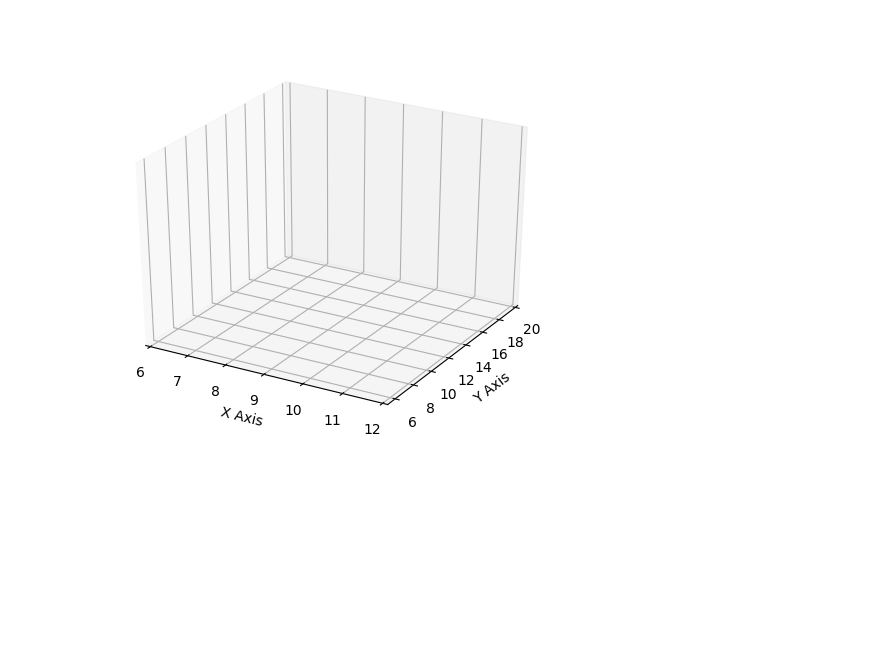

KeyboardInterrupt: 

In [197]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(0,runs):
    if run % 20 == 0:
        ax.clear()
        time = t[run]
        
        ax.scatter(sortedFruit[0,:], sortedFruit[1,:], sortedFruit[2,:], c='r', marker='o')
        
        # check if any fruit was picked at this time?
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0].z_edges_f)

        
        for count in range(num_arms):
            ax.scatter(a[count].qax[run], a[count].qay[run], a[count].qaz[run])

        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.001)
       
    
    
fig.show()

